In [1]:
# !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
# !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

In [2]:
# !unzip Flickr8k_Dataset.zip -d images
# !unzip Flickr8k_text.zip -d captions

## Importing the necessary Libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

In [4]:
# Now setup the GPU configuration
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)


cuda:1


In [5]:
l=os.listdir("images/Flicker8k_Dataset")
print(len(l))

8091


In [6]:
# Location of the Flickr8k_Images folder
images_folder = 'images/Flicker8k_Dataset/'

# Location of captions file
captions_filename = 'captions/Flickr8k.token.txt'

# Load the data
file = open(captions_filename, 'r') 

# Read all captions
captions = file.read()

# Close the file
file.close()

# Split the captions by new line character
captions = captions.split('\n')

# Create a dictionary to store the captions of each image
captions_dict = {}

# Iterate through the captions
for caption in captions:
    # Split the caption by white space
    caption = caption.split()
    
    # The first part of the caption is the image id
    
    
    image_id = caption[0]
    
    # The rest of the caption is the caption
    image_caption = caption[1:]
    
    # Remove the filename from the image id
    image_id = image_id.split('.')[0]
    
    # If the image id is not in the dictionary, add it
    if image_id not in captions_dict:
        captions_dict[image_id] = []
    
    # Add the caption to the list
    captions_dict[image_id].append(image_caption)
    
# Display the first 5 captions of the first image
print(captions_dict['1000268201_693b08cb0e'])




[['A', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.'], ['A', 'girl', 'going', 'into', 'a', 'wooden', 'building', '.'], ['A', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.'], ['A', 'little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her', 'playhouse', '.'], ['A', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'going', 'into', 'a', 'wooden', 'cabin', '.']]


# Let us plot some images and their captions

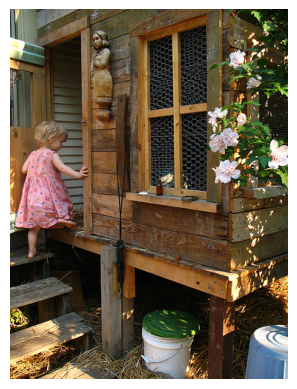

A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .


In [7]:
# Now plot some images and their captions
import cv2

# Load the image
image = cv2.imread(images_folder + '1000268201_693b08cb0e.jpg')

# Convert the image to RGB (OpenCV uses BGR by default)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the image
plt.imshow(image)
plt.axis('off')
plt.show()

# Print the captions of the image
for caption in captions_dict['1000268201_693b08cb0e']:
    print(' '.join(caption))
    


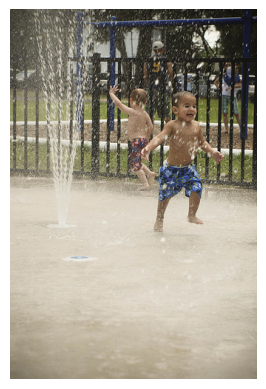

A young boy plays in the water fountain .
a young boy running through a water fountain
Two boys are playing in a sprinkler .
Two boys play in a park fountain .
Two children run through a sprinkler .





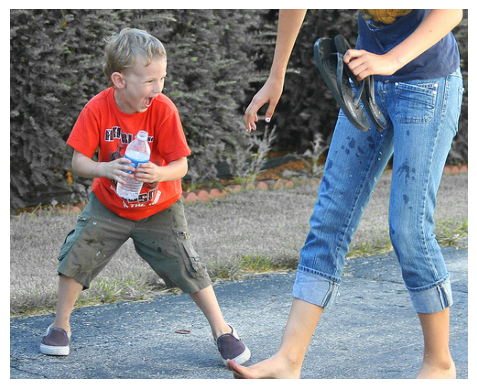

A boy tries to throw water on another person with his water bottle .
A boy wearing a red shirt is splashing water on a woman 's legs .
A boy with a bottle plays with an older girl .
A young boy splashing an older person with a bottle of water
The laughing boy holds a water bottle while a lady with wet pants walks nearby .





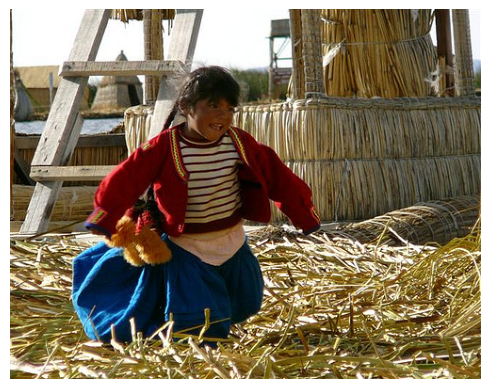

A child in a bright red jacket runs through a pile of hay .
A little girl in a red sweater and blue skirt is in the hay .
A young child dances on a straw surface .
The boy is running through hay at a pumpkin patch .
The child is walking through straw .





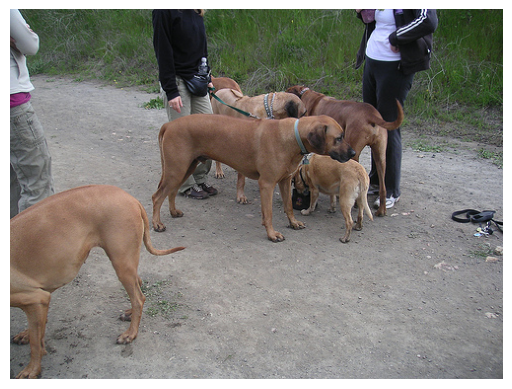

A group of brown dogs are standing on a road with 3 people .
Dogs and their masters gather on a dirt trail .
Several brown dogs of different sizes gather together .
There are 5 brown dogs on leashes with their owners nearby .
Three women are standing among a group of brown dogs .





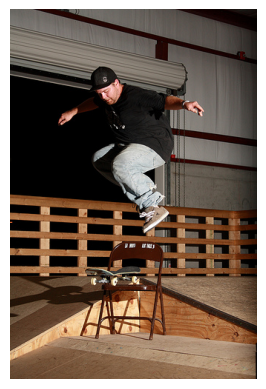

A guy with a black shirt is jumping over a chain on a skateboard .
A man jumps onto a skateboard that is sitting on a folding chair .
A man jumps over a brown chair while skateboarding .
The man in the black hat is jumping over a chair with his skateboard .
The man jumps off the chair .





In [8]:
# Display five random images and their captions
for i in range(5):
    # Get a random image id
    image_id = np.random.choice(list(captions_dict.keys()))
    
    # Load the image
    image = cv2.imread(images_folder + image_id + '.jpg')
    
    # Convert the image to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Plot the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    # Print the captions of the image
    for caption in captions_dict[image_id]:
        print(' '.join(caption))
        
    print('\n\n')
    
    

In [9]:
# Now we will create a vocabulary of all the words in the captions
# Create a set to store the words
vocab = set()

# Iterate through the captions
for key in captions_dict.keys():
    for caption in captions_dict[key]:
        # Add all the words to the set
        vocab.update(caption)
        
# Print the total number of words in the vocabulary
print(f"Total words in the vocabulary: {len(vocab)}")

# Now we will create a dictionary to map each word to an index
word_to_index = {}
index_to_word = {}

# Add a special token for unknown words
word_to_index['<unk>'] = 0
index_to_word[0] = '<unk>'

# Add a special token for the start of the sentence
word_to_index['<start>'] = 1
index_to_word[1] = '<start>'

# Add a special token for the end of the sentence
word_to_index['<end>'] = 2
index_to_word[2] = '<end>'

# Add a special token for padding
word_to_index['<pad>'] = 3
index_to_word[3] = '<pad>'

# Start the index from 4
index = 4

# Iterate through all the words in the vocabulary
for word in vocab:
    # Map the word to the index
    word_to_index[word] = index
    
    # Map the index to the word
    index_to_word[index] = word
    
    # Increment the index
    index += 1
    
# Print the size of the vocabulary
print(f"Total vocabulary size after adding special tokens: {len(word_to_index)}")



Total words in the vocabulary: 9630
Total vocabulary size after adding special tokens: 9634


In [10]:
# Now we will create a function to convert the captions to tensors

def convert_caption_to_tensor(caption, word_to_index, max_length):
    
    # Create a list to store the indexes
    tensor = []
    
    # Add the start token
    tensor.append(word_to_index['<start>'])
    
    # Iterate through all the words in the caption
    for word in caption:
        # If the word is in the word_to_index dictionary
        if word in word_to_index:
            # Add the index of the word to the tensor
            tensor.append(word_to_index[word])
        else:
            # Add the index of the unknown token to the tensor
            tensor.append(word_to_index['<unk>'])
            
        if len(tensor) == max_length-1:
            break
    
    # Add the end token
    tensor.append(word_to_index['<end>'])
    
    # Pad the tensor
    while len(tensor) < max_length:
        tensor.append(word_to_index['<pad>'])
    
    # Convert the tensor to a PyTorch tensor
    tensor = torch.tensor(tensor)
    
    return tensor

# Now we will create a function to convert the images to tensors

def convert_image_to_tensor(image_id, images_folder, image_size=(224, 224)):
    
    # Load the image
    
    image_path = images_folder + image_id + '.jpg'
    if not os.path.exists(image_path):
        print(f"Image file not found: {image_path}")
        return None
    
    image = cv2.imread(image_path)
    
    if image is None:
        print(f"Image not found: {image_path}")
        return None
    
    # check if the image is present

    
    # Convert the image to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize the image
    image = cv2.resize(image, image_size)
    
    # Convert the image to a PyTorch tensor
    image = torch.tensor(image)
    
    return image
        
       
    
# Now we will create a function to create the dataset

class Flickr8kDataset(torch.utils.data.Dataset):
        
        def __init__(self, images_folder, captions_dict, word_to_index, max_length):
            self.images_folder = images_folder
            self.captions_dict = captions_dict
            self.word_to_index = word_to_index
            self.max_length = max_length
            
            # Get the image ids
            self.image_ids = list(captions_dict.keys())
            
        def __len__(self):
            return len(self.image_ids)
        
        def __getitem__(self, index):
            
            # Get the image id of the image
            image_id = self.image_ids[index]
            
            # Get the image tensor
            image = convert_image_to_tensor(image_id, self.images_folder)
            
            # Get the caption tensor
            caption = convert_caption_to_tensor(self.captions_dict[image_id][0], self.word_to_index, self.max_length)
            
            return image, caption
        
# Now we will create the DataLoader

# Set the maximum length of the caption
max_length = 10

# Create the dataset
dataset = Flickr8kDataset(images_folder, captions_dict, word_to_index, max_length)

# Create the DataLoader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

# Get a batch of data
images, captions = next(iter(data_loader))

# Print the shape of the images and captions
print(f"shape of images: {images.shape}")

# Print the shape of the captions
print(f"caption shape: {captions.shape}")

# Print the length of data_loader
print(f"Length of data_loader: {len(data_loader)}")



shape of images: torch.Size([256, 224, 224, 3])
caption shape: torch.Size([256, 10])
Length of data_loader: 32


In [11]:
# Now we will create the Encoder using a pre-trained ResNet model

class Encoder(nn.Module):
    
    def __init__(self, embed_size):
        super(Encoder, self).__init__()
        
        # Load the ResNet model
        resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
        
        # Remove the classification layer
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        
        # Create the linear layer
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        
        # Create the batch normalization layer
        # self.batch_norm = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, x):
        
        # Pass the image through the ResNet model
        x = x.float()/255
        x = x.permute(0, 3, 1, 2)
        
        x = self.resnet(x)
        
        # Flatten the output
        x = x.view(x.size(0), -1)
        
        # Pass the output through the linear layer
        x = self.linear(x)
        
        # Pass the output through the batch normalization layer
        # x = self.batch_norm(x)
        
        return x
    
# Create the encoder
encoder = Encoder(256)

# Pass the images through the encoder
features = encoder(images)

# Print the shape of the features
print(f"features shape: {features.shape}")



Using cache found in /raid/home/gnaneswaras/.cache/torch/hub/pytorch_vision_v0.6.0


features shape: torch.Size([256, 256])


In [12]:
# Now we will create the Decoder

class Decoder(nn.Module):
        
        def __init__(self, embed_size, hidden_size, vocab_size, max_length, num_layers=1):
            super(Decoder, self).__init__()
            
            self.embed = nn.Embedding(vocab_size, embed_size)
            
            # self.feature_to_hidden = nn.Linear(256, hidden_size)
            # self.feature_to_cell = nn.Linear(256, hidden_size)
            
            self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
            
            self.linear = nn.Linear(hidden_size, vocab_size)
            
            self.max_length = max_length
            
            self.num_layers = num_layers
            
            self.hidden_size = hidden_size 
            
        def forward(self, features, captions):
                
                # Create the initial hidden and cell states
                # hidden = self.feature_to_hidden(features)
                # cell = self.feature_to_cell(features)
                
                # hidden = torch.zeros(1, features.size(0), 512).to(device)
                # cell = torch.zeros(1, features.size(0), 512).to(device)
                
                # Create the embedded captions
                captions = captions[:, :-1]
                captions = captions.to(device)
                embeddings = self.embed(captions).to(device)
                
                features = features.to(device)
                # Concatenate the features and captions
                features = features.unsqueeze(1)
                
                # Pass the features and captions through the LSTM
                lstm_inputs = torch.cat((features, embeddings), dim=1)
                
                # outputs, _ = self.lstm(lstm_inputs, (hidden, cell))
                outputs, _ = self.lstm(lstm_inputs)
                
                # Pass the outputs through the linear layer
                outputs = self.linear(outputs)
                
                return outputs
            
        def sample(self, features, states=None):
            
            # Create a list to store the output words
            sampled_ids = []
            
           
            features = features.to(device)
            # hidden = torch.zeros(1, features.size(0), 512).to(device)
            # cell = torch.zeros(1, features.size(0), 512).to(device)
            
            hidden,cell = (torch.randn(self.num_layers,1,self.hidden_size).to(device),torch.randn(self.num_layers,1,self.hidden_size).to(device))
            
            # Create a tensor to store the input word
            inputs = features.unsqueeze(1)
            
            for i in range(self.max_length):
                
                # Pass the inputs through the LSTM
                outputs, (hidden, cell) = self.lstm(inputs, (hidden, cell))
                
                # Pass the outputs through the linear layer
                outputs = self.linear(outputs)
                
                # Get the index of the word with the maximum score
                
                outputs = outputs.squeeze(1)
                
                predicted = outputs.argmax(1)
                # predicted = outputs.argmax(2)
                
                # Append the word to the list
                
                
                # Break if the word is the end token
                if predicted.item() == 2:
                    break
                
                sampled_ids.append(predicted.item())
                
                # Create the inputs for the next iteration
                inputs = self.embed(predicted.unsqueeze(0))
                
            return sampled_ids
            
        
        
# Create the decoder
decoder = Decoder(256, 512, len(word_to_index), max_length).to(device)

# Pass the features and captions through the decoder
outputs = decoder(features, captions)


# Print the shape of the outputs
print(f"outputs shape: {outputs.shape}")




outputs shape: torch.Size([256, 10, 9634])


In [13]:
# Now we will create the model

class ImageCaptioningModel(nn.Module):
    
    def __init__(self, encoder, decoder):
        super(ImageCaptioningModel, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, images, captions):
        
        # Pass the images through the encoder
        features = self.encoder(images)
        
        # Pass the features and captions through the decoder
        outputs = self.decoder(features, captions)
        
        
        
        return outputs
    
# Create the model
model = ImageCaptioningModel(encoder, decoder)

# Pass the images and captions through the model
outputs = model(images, captions)

# Print the shape of the outputs
print(f"outputs shape: {outputs.shape}")




outputs shape: torch.Size([256, 10, 9634])


In [14]:
# Now we will create the loss function and the optimizer

# Create the loss function


model.to(device)
criterion = nn.CrossEntropyLoss()

# Create the optimizer
params = list(model.encoder.linear.parameters()) + list(model.decoder.parameters())

optimizer = optim.Adam(params, lr=0.001)

# Now we will train the model

# Set the number of epochs
num_epochs = 5

# Iterate through the epochs

for epoch in range(num_epochs):
        
        # Set the model to train mode
        model.train()
        
        # Iterate through the data loader
        for images, captions in data_loader:        
            # Pass the images and captions through the model
            model.encoder.zero_grad()
            model.decoder.zero_grad()
            
            images, captions = images.to(device), captions.to(device)    
            outputs = model(images, captions)           
            
             
            loss = criterion(outputs.view(-1, len(word_to_index)), captions.view(-1))
            
           
            
            # Zero the gradients
            # optimizer.zero_grad()
            
            # Backward pass
            loss.backward()
            
            # Update the weights
            optimizer.step()
            
            
            # print(f"loss {loss}")
        # Print the loss
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
        
# Save the model
torch.save(model.state_dict(), 'model.pth')



Epoch 1, Loss: 3.9330737590789795
Epoch 2, Loss: 3.2833333015441895
Epoch 3, Loss: 3.118746519088745
Epoch 4, Loss: 2.853344202041626
Epoch 5, Loss: 2.705050468444824


In [15]:
# Load the saved model
model.load_state_dict(torch.load('model.pth'))


<All keys matched successfully>

In [16]:
print(device)

cuda:1


torch.Size([1, 224, 224, 3])
torch.Size([1, 10])
torch.Size([1, 10, 9634])
torch.Size([1, 256])
tensor([[   1, 4573, 3517, 6554, 4771, 7301, 3112, 8433, 9430,    2]],
       device='cuda:1')
[1, 5727, 2450, 3631, 8186, 3007, 7707, 6687, 1289, 2]
<start> A man in a blue shirt is standing <end> 

Actual Caption: tensor([   1, 4573, 3517, 6554, 4771, 7301, 3112, 8433, 9430,    2],
       device='cuda:1')
<start> African American men receiving plates of food out <end> 

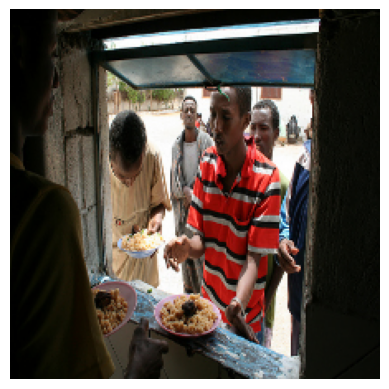

In [30]:
# Now lets do some predictions

# Set the model to evaluation mode
model.eval()

# Get exactly one image and caption from batch of data
images, captions = next(iter(data_loader))

# Pass the image through the model
image = images[0].unsqueeze(0).to(device)
caption = captions[0].unsqueeze(0).to(device)


print(image.shape)
print(caption.shape)

# Pass the image through the model
outputs = model(image, caption)

print(outputs.shape)

# Get the predicted caption

print(encoder(image).shape) 

print(caption)
predicted_caption = decoder.sample(encoder(image))

print(predicted_caption)
# Print the predicted caption
for word_id in predicted_caption:
    word = index_to_word[word_id]
    print(word, end=' ')
    
# Print the actual caption
print('\n\nActual Caption:',caption[0])
for word_id in caption[0]:
    word = index_to_word[word_id.item()]
    print(word, end=' ')
    
#plot the image
image = image[0].cpu().numpy()
# image = np.transpose(image, (1, 2, 0))
plt.imshow(image)
plt.axis('off')
plt.show()



In [18]:
# Now calculate the BLEU score
torch.cuda.empty_cache()
from nltk.translate.bleu_score import sentence_bleu

# Set the model to evaluation mode
model.eval()

# Create a list to store the actual and predicted captions
actual_captions = []
predicted_captions = []

# Iterate through the data loader
for images, captions in data_loader:    
    for i in range(images.shape[0]):
        image = images[i].unsqueeze(0).to(device)
        caption = captions[i].unsqueeze(0).to(device)
        
        # Pass the image through the model
        outputs = model(image, caption)
        
        # Get the predicted caption
        predicted_caption = decoder.sample(encoder(image))
        
        # Append the actual and predicted captions
        actual_captions.append(caption)
        predicted_captions.append(predicted_caption)
        
# Print the length of the actual and predicted captions
print(f"Length of actual captions: {len(actual_captions)}")
print(f"Length of predicted captions: {len(predicted_captions)}")

 


Length of actual captions: 8091
Length of predicted captions: 8091


In [19]:
# Predicted sentences and actual sentences
predicted_sentences = []
actual_sentences = []

# Iterate through the predicted and actual captions

for predicted_caption, actual_caption in zip(predicted_captions, actual_captions):
    
    # Create a list to store the words
    predicted_sentence = []
    actual_sentence = []
    
    # Iterate through the predicted caption
    for word_id in predicted_caption:
        word = index_to_word[word_id]
        
        # Append the word to the list
        predicted_sentence.append(word)
        
        # Break if the word is the end token
        if word == '<end>':
            break
        
    # Iterate through the actual caption
    for word_id in actual_caption[0]:
        word = index_to_word[word_id.item()]
        
        # Append the word to the list
        actual_sentence.append(word)
        
        # Break if the word is the end token
        if word == '<end>':
            break
        
    # remove the start token and end token in actual sentence
    
    actual_sentence = actual_sentence[1:-1]
    predicted_sentence = predicted_sentence[1:-1]
        
    # Append the sentence to the list
    predicted_sentences.append(predicted_sentence)
    actual_sentences.append(actual_sentence)
    
    


In [20]:
print(actual_sentences)

[['A', 'man', 'is', 'placing', 'jewelry', 'on', 'an', 'extravagantly-haired'], ['A', 'group', 'of', 'people', 'surf', 'on', 'a', 'very'], ['A', 'brown', 'haired', 'man', 'is', 'wearing', 'a', 'blue'], ['A', 'boy', 'belly-surfing', 'a', 'skateboard', 'into', 'a', 'pile'], ['A', 'brown', 'and', 'white', 'dog', 'bares', 'his', 'teeth'], ['A', 'boy', 'skateboards', 'and', 'does', 'a', 'jump', 'over'], ['A', 'man', 'and', 'a', 'skateboard', 'on', 'top', 'of'], ['A', 'man', 'dressed', 'for', 'cold', 'weather', 'plays', 'with'], ['Three', 'children', 'are', 'playing', 'in', 'sand', 'near', 'to'], ['A', 'girl', 'runs', 'past', 'a', 'large', 'model', 'of'], ['a', 'group', 'enjoying', 'a', 'day', 'at', 'the', 'park'], ['A', 'child', 'in', 'the', 'snow', 'with', 'a', 'house'], ['A', 'child', 'rides', 'on', 'a', 'man', "'s", 'shoulders'], ['A', 'brown', 'dog', 'is', 'carrying', 'a', 'wet', 'stick'], ['A', 'boy', 'does', 'a', 'cannonball', 'into', 'a', 'pool'], ['A', 'black', 'and', 'brown', 'dog',

In [21]:
print(predicted_sentences)

[['A', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'jumping'], ['A', 'man', 'in', 'a', 'blue', 'shirt', 'is'], ['A', 'man', 'in', 'a', 'blue', 'shirt', 'is'], ['A', 'man', 'in', 'a', 'blue', 'shirt', 'is'], ['A', 'man', 'in', 'a', 'blue', 'shirt', 'is'], ['A', 'man', 'in', 'a', 'blue', 'shirt', 'is'], ['A', 'man', 'in', 'a', 'blue', 'shirt', 'is'], ['A', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'jumping'], ['A', 'man', 'in', 'a', 'blue', 'shirt', 'is'], ['A', 'man', 'in', 'a', 'blue', 'shirt', 'is'], ['A', 'man', 'in', 'a', 'blue', 'shirt', 'is'], ['A', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'jumping'], ['A', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'jumping'], ['A', 'man', 'in', 'a', 'blue', 'shirt', 'is'], ['A', 'man', 'in', 'a', 'blue', 'shirt', 'is'], ['A', 'man', 'in', 'a', 'blue', 'shirt', 'is'], ['A', 'man', 'in', 'a', 'blue', 'shirt', 'is'], ['A', 'man', 'in', 'a', 'blue', 'shirt', 'is'], ['A', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'jumping'], ['A', 'man', 'in', 'a', 'blue', 

In [22]:
# Now calculate the BLEU score
bleu_score = 0

# Iterate through the sentences
for predicted_sentence, actual_sentence in zip(predicted_sentences, actual_sentences):
    
    # Calculate the BLEU score
    bleu_score += sentence_bleu([actual_sentence], predicted_sentence)
    
print(bleu_score)
# Calculate the average BLEU score
bleu_score /= len(predicted_sentences)

# Print the BLEU score
print(f"BLEU score: {bleu_score}")

/raid/home/gnaneswaras/.local/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/raid/home/gnaneswaras/.local/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/raid/home/gnaneswaras/.local/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-g

112.48635794146897
BLEU score: 0.01390265207532678
